### Preliminary analysis of scRNA-seq data for Foxp3 degradation in Treg cells

We will run DESeq twice; first to filter out any genes differential at D0 (no drug added), and then a second time to get the DEGs for D3 and D7. In this notebook, we create the matrices for the first pass of DESeq2. The second and third notebooks deal with creating matrices for the second pass of DESeq2, as well as downstream analysis.

In [1]:
%load_ext autoreload
import scanpy as sc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sc.set_figure_params(figsize=(5,5)) # no blurry figures allowed
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [3]:
%autoreload 2 
import sys
sys.path.append('./code/')

from init_global_vars import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sklearn
import scipy

print('sc:', sc.__version__)
print('sklearn:', sklearn.__version__)
print('np:', np.__version__)
print('scipy:', scipy.__version__)

sc: 1.9.3
sklearn: 1.3.0
np: 1.23.5
scipy: 1.11.2


## Load and preprocess data

Load the adata object; set up some columns in adata.obs for plotting later on

In [5]:
adata = sc.read('data/treg_rna_scrna.h5ad')

In [6]:
adata.obs['is_wt'] = adata.obs['sample'].str.contains("wt").astype(int)
adata.obs['is_d7_wt'] = adata.obs['sample'].str.contains("D7_wt").astype(int)
adata.obs['is_d3_wt'] = adata.obs['sample'].str.contains("D3_wt").astype(int)
adata.obs['is_d0_wt'] = adata.obs['sample'].str.contains("D0_wt").astype(int)

adata.obs['is_d7_tir1'] = adata.obs['sample'].str.contains("D7_tir1").astype(int)
adata.obs['is_d3_tir1'] = adata.obs['sample'].str.contains("D3_tir1").astype(int)
adata.obs['is_d0_tir1'] = adata.obs['sample'].str.contains("D0_tir1").astype(int)
adata.obs['is_tir1_d7'] = adata.obs['sample'].str.contains("D7_tir1").astype(int)
adata.obs['dereplicate_sample'] = ["_".join(x.split("_")[:2]) for x in adata.obs['sample']]

In [7]:
# mitochondrial gene names may start with "Mt-" instead of "mt-""
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [8]:
adata.obs["high_mt"] = adata.obs["pct_counts_mt"] >= 7 ## this is still a pretty permissible threshold
adata.obs["high_counts"] = adata.obs["total_counts"] >= 40000

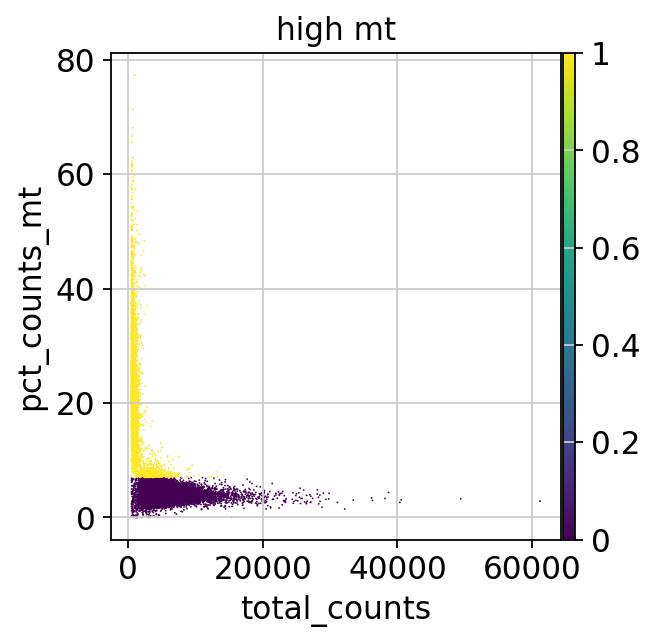

In [9]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="high_mt")
adata = adata[~adata.obs['high_mt'], :]

In [10]:
## Filter cells/genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.shape

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


filtered out 14564 genes that are detected in less than 3 cells


(40620, 17721)

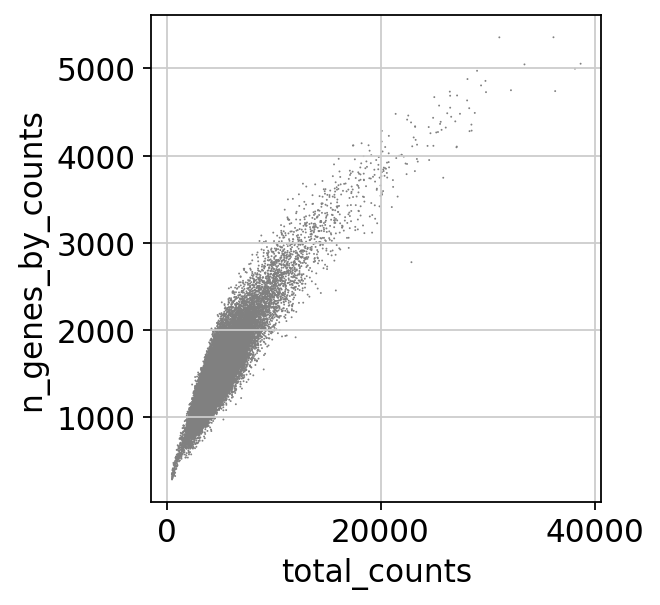

In [11]:
sc.pl.scatter(adata[adata.obs["total_counts"] <= 40000], x='total_counts', y='n_genes_by_counts') 

#### Initialize global variables

In [12]:
DAY_PLOT_ORDER = ['D0_wt', 'D0_tir1', 'D3_wt', 'D3_tir1', 'D7_wt', 'D7_tir1']
PLOT_ORDER = ['D0_wt', 'D3_wt', 'D7_wt', 'D0_tir1', 'D3_tir1', 'D7_tir1']
samples = pd.Series(adata.obs['sample'].unique().astype(str))
DEREPLICATE_PLOT_ORDER = []
for x in PLOT_ORDER:
    DEREPLICATE_PLOT_ORDER += list(samples[samples.str.contains(x)])

#### Remove non-protein coding genes

In [13]:
import liftover
from liftover_functions import liftover_bedtool
from gtf_functions import make_tss_df

gtf_file = pbt.BedTool('bulk_rna_data/annotations/gencode.vM23.annotation.gtf')
transcripts_file = gtf_file.filter(lambda b: b[2] == 'transcript').saveas()

my_tss_df, my_transcript_df = make_tss_df(transcripts_file)
my_tss_df = my_tss_df.loc[(my_tss_df['transcript_type'] == 'protein_coding')]

In [14]:
genesoi = adata.var.index[adata.var.index.isin(my_tss_df['gene_name'])]
adata = adata[:, genesoi]

### Set up parameters for filtering

In [15]:
adata.obs['counts_per_cell'] = (adata.X).sum(axis=1)
adata.obs['genes_per_cell'] = (adata.X > 0).sum(axis=1)

/tmp/ipykernel_2394296/3108485978.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['counts_per_cell'] = (adata.X).sum(axis=1)


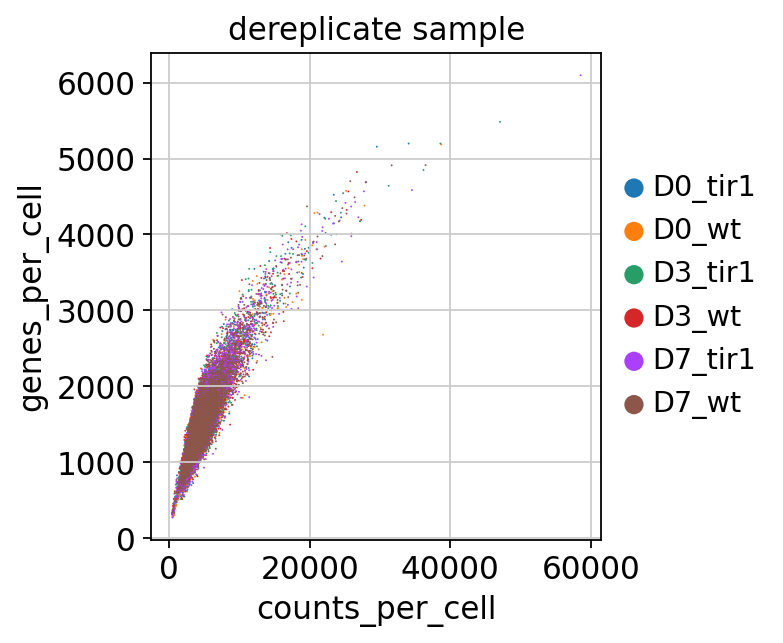

In [16]:
sc.pl.scatter(adata, x='counts_per_cell', y='genes_per_cell', color='dereplicate_sample')

Text(0, 0.5, 'Genes per cell')

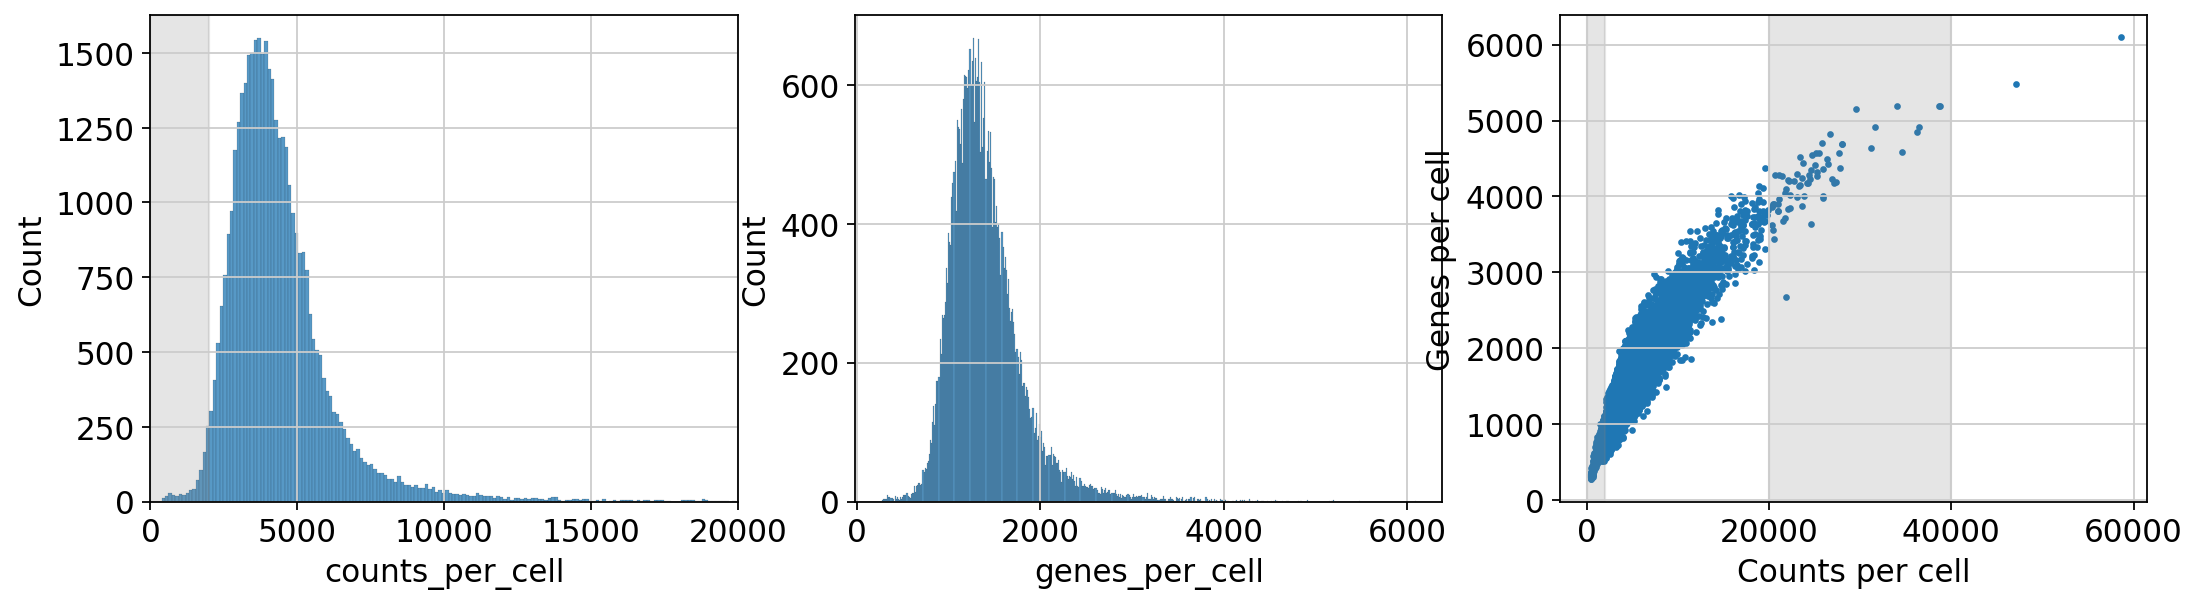

In [17]:
too_few_counts = 2000
too_high_counts = 20_000

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(adata.obs['counts_per_cell'], bins=500, ax=ax[0])
sns.histplot(adata.obs['genes_per_cell'], bins=500, ax=ax[1])
ax[2].scatter(adata.obs['counts_per_cell'], adata.obs['genes_per_cell'], s=4)
ax[0].axvspan(0, too_few_counts, color='gray', alpha=.2)
ax[0].axvspan(too_high_counts, 20_000, color='gray', alpha=.2)
ax[0].set_xlim([0, 20_000])

ax[2].axvspan(0, too_few_counts, color='gray', alpha=.2)
ax[2].axvspan(too_high_counts, 40_000, color='gray', alpha=.2)
ax[2].set_xlabel('Counts per cell')
ax[2].set_ylabel('Genes per cell')

In [18]:
adata = adata[adata.obs['counts_per_cell'] > too_few_counts, :]
adata = adata[adata.obs['counts_per_cell'] < too_high_counts, :]

In [19]:
adata_with_all_genes = adata.copy()

In [20]:
adata.layers["raw_counts"]  = adata.X.copy()

### Filter genes present in too few cells

In [21]:
import numpy as np

In [22]:
adata.var['mean_cells_per_gene'] = np.ravel((adata.layers['raw_counts'].todense() > 0).mean(axis=0))
adata.var['frac_cells_per_gene'] = np.ravel((adata.layers['raw_counts'].todense() > 0).mean(axis=0))
adata.var['n_cells_per_gene'] = np.ravel((adata.layers['raw_counts'].todense() > 0).sum(axis=0))
adata.var['counts_per_gene'] = np.ravel((adata.layers['raw_counts'].todense()).sum(axis=0))
adata.var['mean_counts_per_gene'] = np.ravel((adata.layers['raw_counts'].todense()).mean(axis=0))
adata.var['var_per_gene'] = np.ravel((adata.layers['raw_counts'].todense()).var(axis=0))

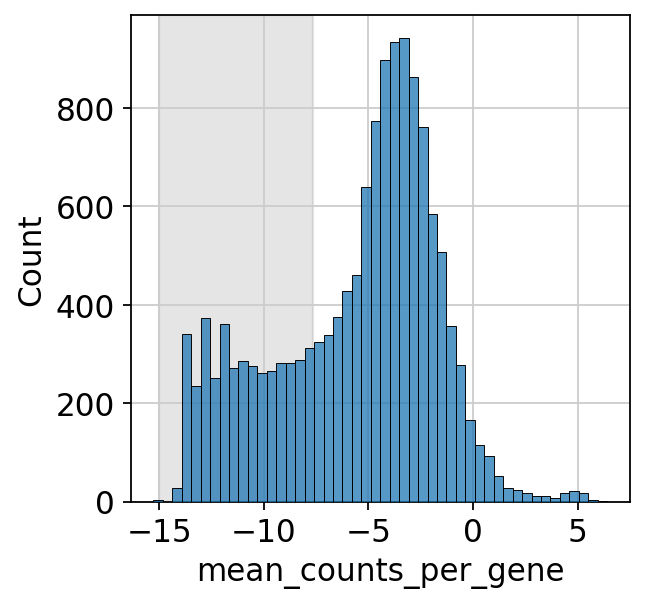

In [23]:
too_few_counts = .005
# too_few_counts = .01
xs = np.log2(adata.var['mean_counts_per_gene'])
fig, ax = plt.subplots()
sns.histplot(xs, ax=ax, zorder=3)
ax.axvspan(-15, np.log2(too_few_counts), color='gray', alpha=.2)

In [24]:
adata = adata[:, adata.var['mean_counts_per_gene'] > too_few_counts]

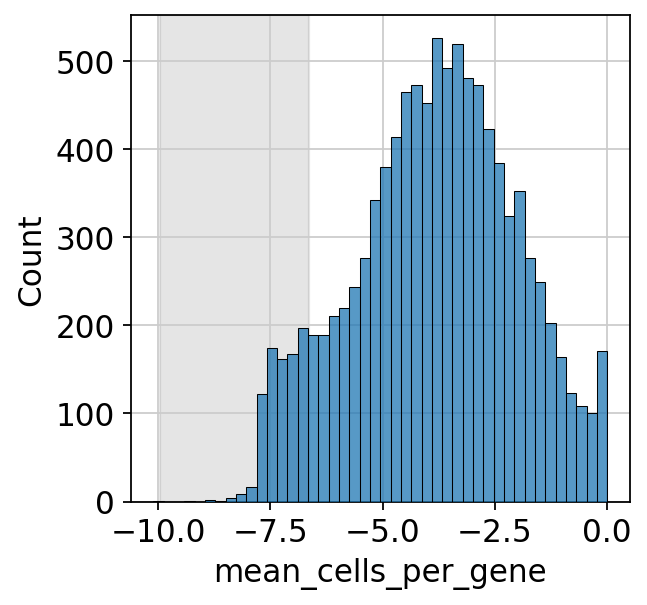

In [25]:
too_few_cells = .01
# too_few_counts = .01
xs = np.log2(adata.var['mean_cells_per_gene'])
fig, ax = plt.subplots()
sns.histplot(xs, ax=ax, zorder=3)
ax.axvspan(np.log2(1e-3), np.log2(too_few_cells), color='gray', alpha=.2)

In [26]:
adata = adata[:, adata.var['mean_cells_per_gene'] > too_few_cells]

### Further filtering

In [27]:
sc.pp.filter_cells(adata, min_genes=10 ** 2.5)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

high_counts = adata.obs['n_genes_by_counts'] > 3500
adata = adata[~high_counts, :]

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


#### Drop Immune receptor genes, pseudogenes, and unannotated genes

We're removing TCR/BCR genes, pseudo genes, and unannotated genes.

In [28]:
tcr_bcr_genes = ['Igha', 'Igkc', 'Jchain', 
            'Trav5-1', 'Trav14d-3-dv8', 'Trav16n', 'Trav14n-3',
            'Trav7-5', 'Trav13-1', 'Trav14-1', 'Trav4-3', 'Trav12-2', 'Trav14-2',
            'Trav3-3', 'Trav4-4-dv10', 'Trav5-4', 'Trav6-7-dv9', 'Trav16',
            'Trav14-3', 'Trav21-dv12', 'Ighd', 'Ighm', 
            'Trbv1', 'Trbv2', 'Trbv3', 'Trbv12-1', 'Trbv13-1', 'Trbv12-2',
            'Trbv13-2', 'Trbv13-3', 'Trbv15', 'Trbv16', 'Trbv19', 'Trbv20',
            'Trbv26', 'Trbv31', 'Ptcra', 'Trdc', 'Iglc1',
            ]

print('Removing: ', adata.var.index[adata.var.index.isin(tcr_bcr_genes)].shape, ' TCR/BCR genes')
print('Removing: ', adata.var.index[adata.var.index.str.contains("-ps1")].shape, ' "-ps1" genes')
print('Removing: ', adata.var.index[adata.var.index.str.contains("Gm")].shape, ' "Gm" genes')

adata = adata[:, ~adata.var.index.isin(tcr_bcr_genes)]

# Drop pseudo genes
adata = adata[:, adata.var.index[~adata.var.index.str.contains("-ps1")]]

# Drop Gm genes
adata = adata[:, ~adata.var.index.str.contains("Gm")]

Removing:  (1,)  TCR/BCR genes
Removing:  (4,)  "-ps1" genes
Removing:  (57,)  "Gm" genes


## Pearson residual normalization

We normalize the adata object using pearson residual normalization

In [29]:
def normalize_data(ad, theta):
    gene_means = pd.DataFrame()
    ad.X = ad.layers["raw_counts"].copy()
    sc.experimental.pp.normalize_pearson_residuals(ad, theta = theta, inplace = True)
    lay = "theta_"+ str(round(theta, 1))
    ad.layers[lay] = ad.X.copy()

In [30]:
normalize_data(adata, theta=10)

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:123: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing analytic Pearson residuals on adata.X
    finished (0:00:04)


In [31]:
adata.X = adata.layers["theta_10"].copy()
adata.layers

Layers with keys: raw_counts, theta_10

### Process & cluster the scRNA-seq data

We process & cluster using 100 PCs followed by conventional scRNA-seq pipelines.

In [32]:
n_pcs = 100
sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs, use_rep='X_pca', metric="cosine")
sc.tl.leiden(adata, resolution = 1)
sc.tl.umap(adata)

computing PCA
    with n_comps=100
    finished (0:00:34)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Genomics/argo/users/g

    computed neighbors (0:00:34)
    computed connectivities (0:00:07)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:22)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:38)


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


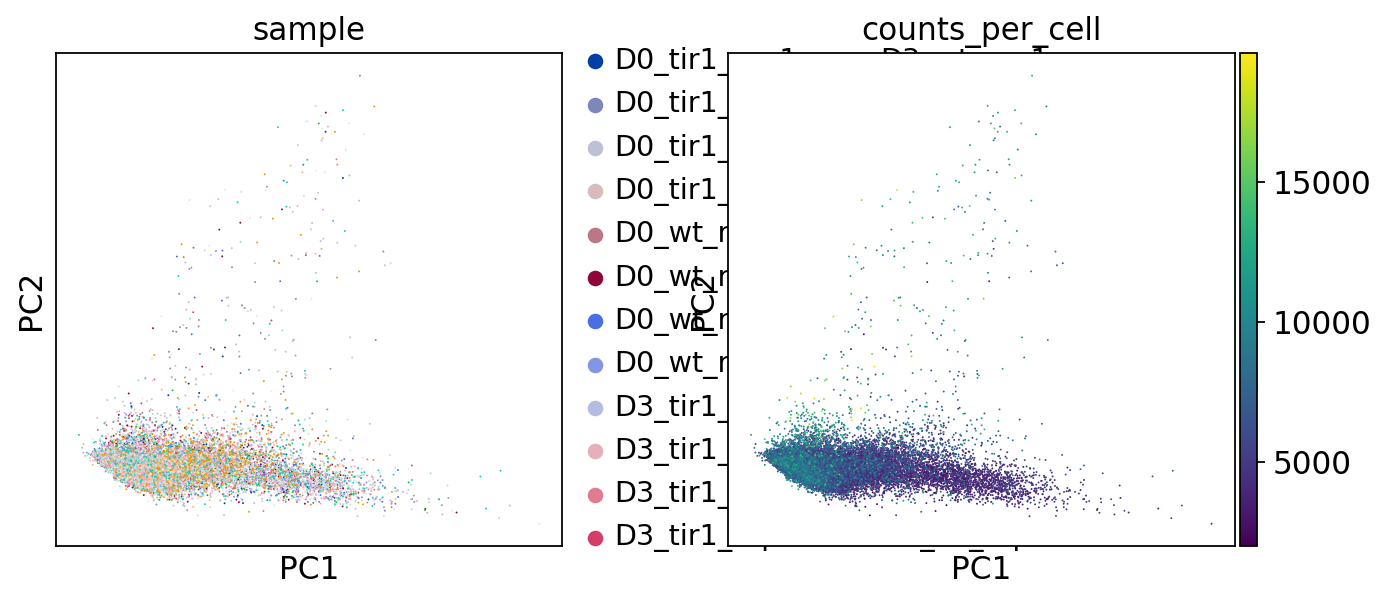

In [33]:
sc.pl.pca_scatter(adata, color=['sample', 'counts_per_cell'])

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


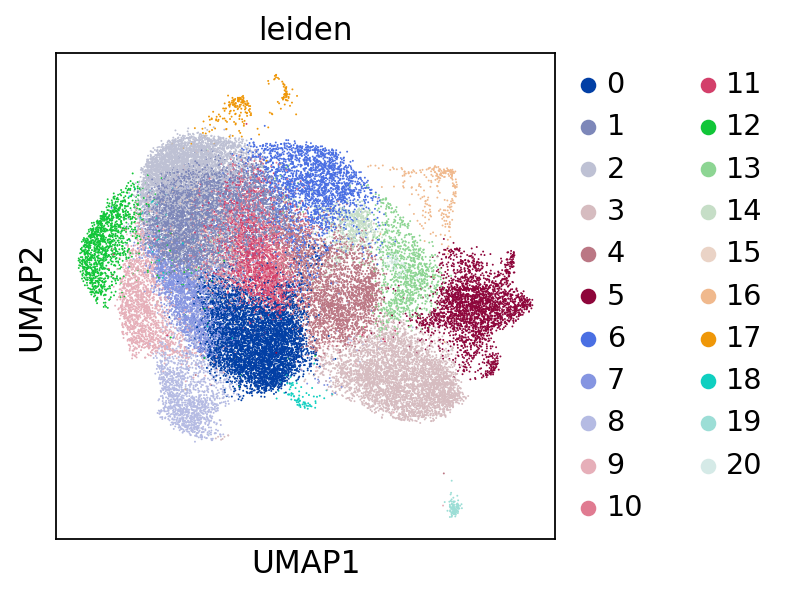

In [34]:
sc.pl.umap(adata, color=['leiden'])

#### Visualize most highly expressed genes in each leiden cluster

To determine whether any clusters are composed of artifactual cells, we look at the most highly expr

In [35]:
from aux_functions_scRNA import *

# df with averaged pearson residuals for each leiden
agg = aggregate_adata_by_obs_column(adata, key='leiden', layer='theta_10')

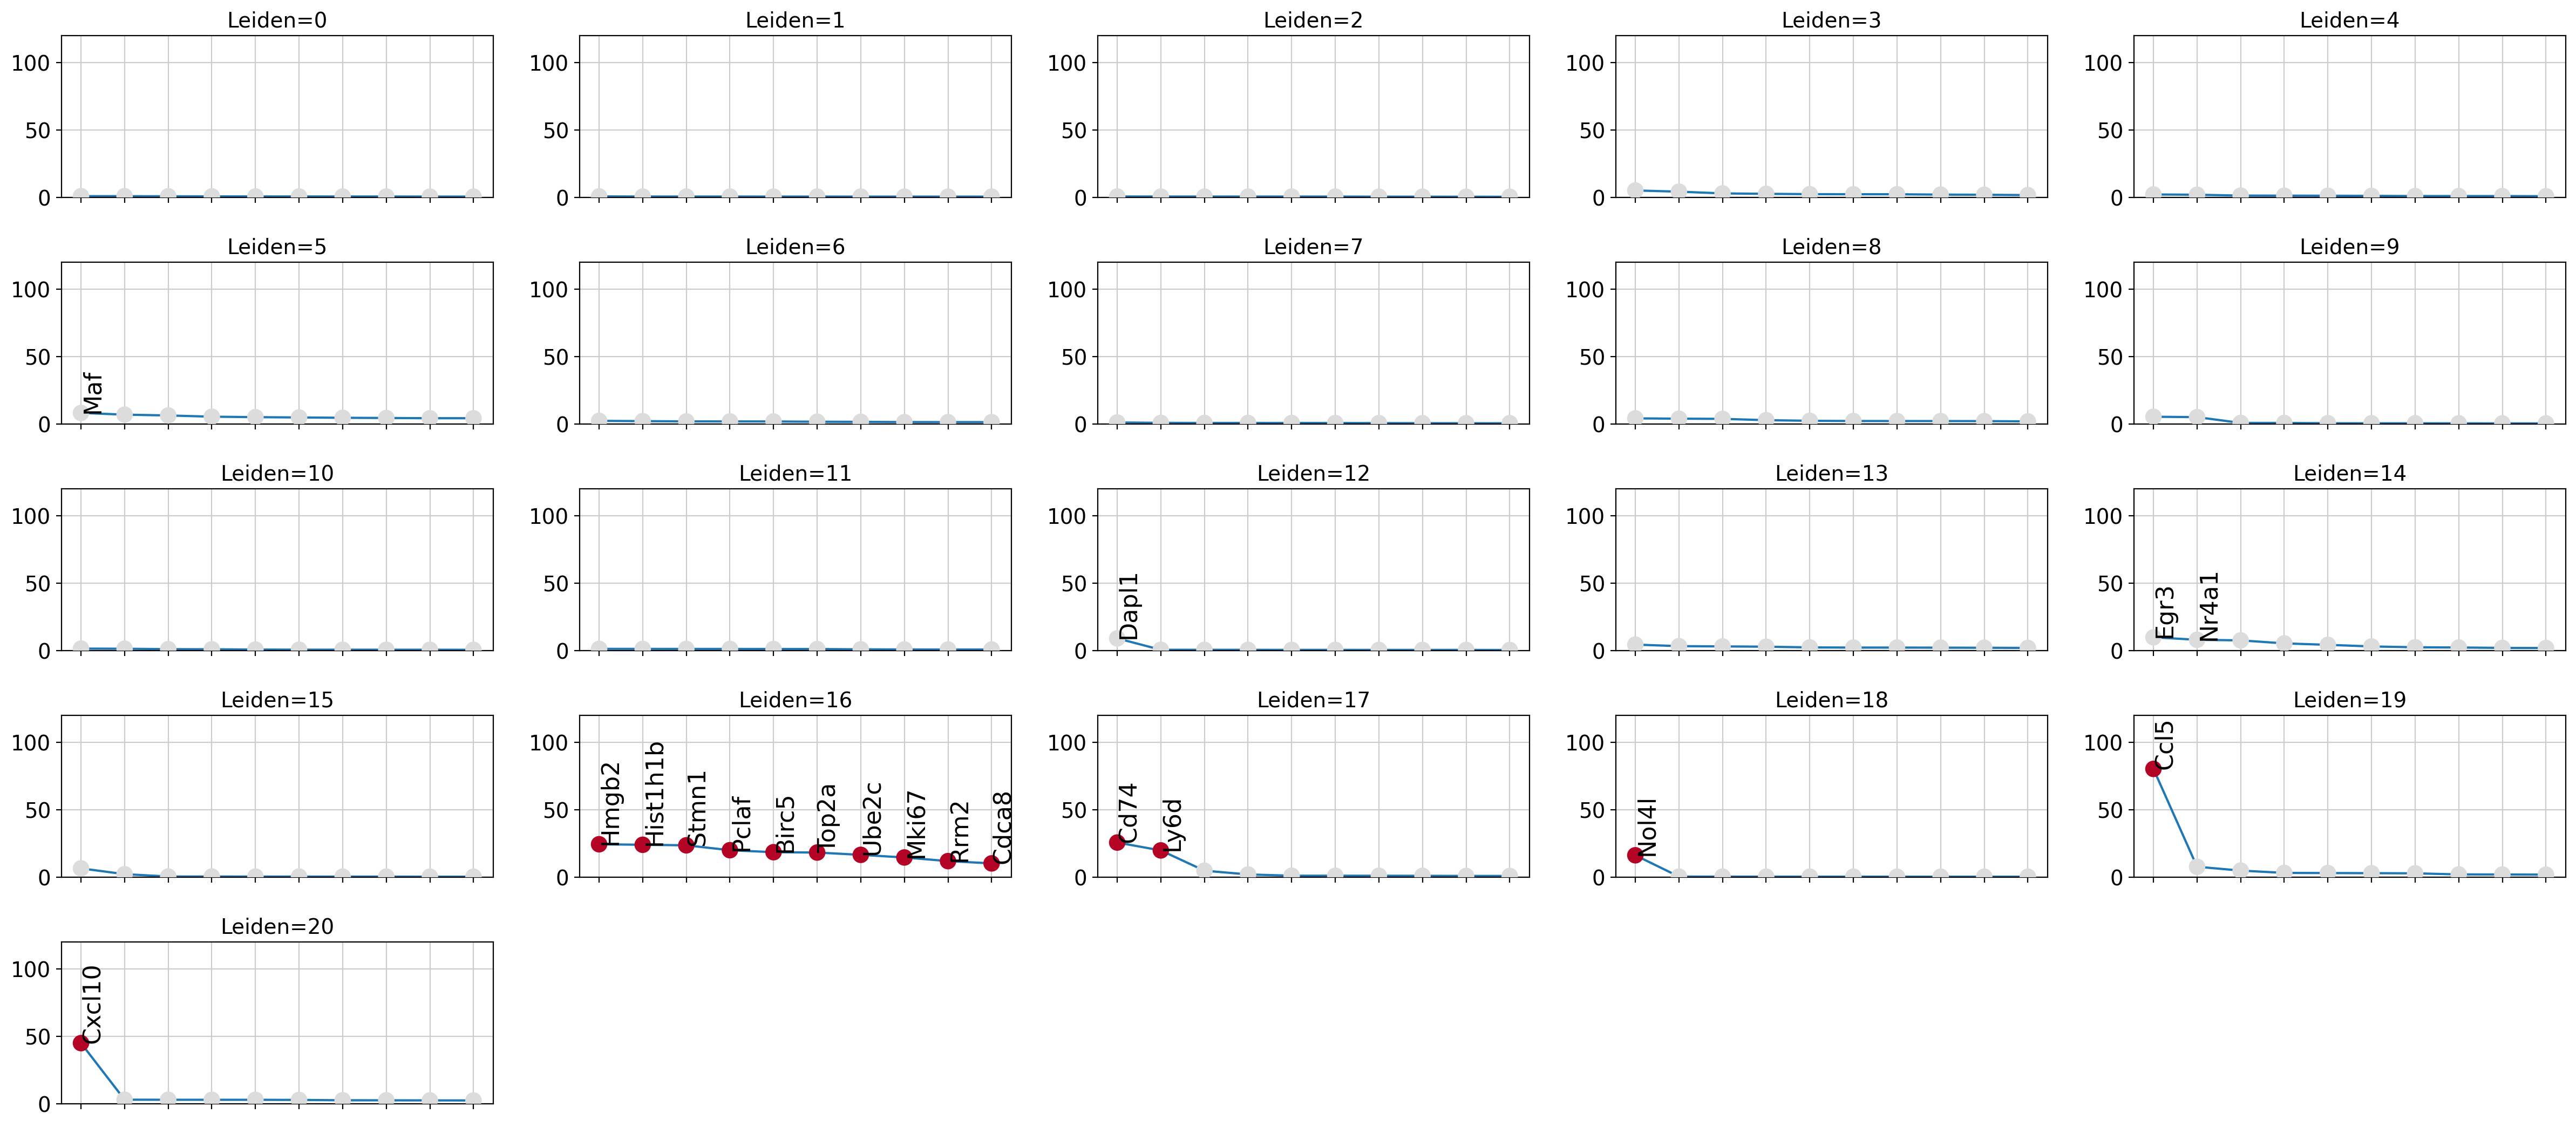

In [36]:
from plotting_functions import *
from collections import defaultdict

clusters_with_outliers = defaultdict(list)

n = len(agg.columns)
fig, axs = init_subplots_exact(n, n//4, fgsz=(4, 1.5), yspace=1.4, dpi=100)
for c, leiden in enumerate(sorted(agg.columns.astype(int))):
    leiden = str(leiden)
    plt.sca(axs[c])
    data = agg[leiden].sort_values(ascending=False).iloc[:10]
    ps = []
    for i in data.index:
        idx = adata.obs['leiden'].isin([leiden])
        vals_in = np.ravel(adata[idx, i].X)
        vals_out = np.ravel(adata[~idx, i].X)
        _, p = scipy.stats.ranksums(vals_in, vals_out)
        ps.append(p)
    x = data.index
    y = data.values
    ps = arr(ps)
    c = ((ps < 1e-10) & (y > 10)).astype(int)
    plt.plot(x, y)
    plt.scatter(x, y, c=c, marker='o', cmap='coolwarm', vmin=-1, vmax=1, s=100, zorder=3)
    for c2, i in enumerate(x):
        if y[c2] > 8:
            clusters_with_outliers[leiden].append(x[c2])
            plt.text(c2, y[c2], x[c2], fontsize=16, rotation=90, va='bottom')
    plt.xticks(rotation=90)
    plt.ylim([0, 120])
    plt.gca().set_xticklabels([])
    plt.title(f'Leiden={leiden}')
    plt.gca().set_axisbelow(True)

Clusters 17 and 19 look artifactual. Cluster 17 is high in Cd74 and Ly6d, which are overexpressed in pDCs. Cluster 19 is high in Ccl5, which could be expressed in both T-cells and NK cells. We import pDC and NK gene sets from Immgen to determine whether these are non-Treg cells

In [37]:
from scipy.stats import zscore
## Import immgen RNA-seq; z-score across cell types

immgen_data = pd.read_csv('./immgen_data/GSE15907_Normalized_Data.csv', index_col=0)
immgen_data = immgen_data.set_index('GeneSymbol')
immgen_data = immgen_data.apply(zscore, axis=1)

# Select pDC and NK cell types from the spleen / lymph node
nk_sp_cols = immgen_data.columns[immgen_data.columns.str.contains("NK", regex=False) & immgen_data.columns.str.contains("Sp", regex=False)]
nk_sln_cols = immgen_data.columns[immgen_data.columns.str.contains("NK", regex=False) & immgen_data.columns.str.contains("SLN", regex=False)]
pdc_sp_cols = immgen_data.columns[immgen_data.columns.str.contains("pDC", regex=False) & immgen_data.columns.str.contains("Sp", regex=False)]
pdc_sln_cols = immgen_data.columns[immgen_data.columns.str.contains("pDC", regex=False) & immgen_data.columns.str.contains("SLN", regex=False)]

### Select top 100 NK/pDC-specific genes
nk_sp_genes = immgen_data[nk_sp_cols].mean(axis=1).sort_values().index[-100:]
nk_sln_genes = immgen_data[nk_sln_cols].mean(axis=1).sort_values().index[-100:]
pdc_sp_genes = immgen_data[pdc_sp_cols].mean(axis=1).sort_values().index[-100:]
pdc_sln_genes = immgen_data[pdc_sln_cols].mean(axis=1).sort_values().index[-100:]

Score adata on genes from Immgen

In [38]:
sc.tl.score_genes(adata, nk_sp_genes, score_name='nk_sp_cells')
sc.tl.score_genes(adata, nk_sln_genes, score_name='nk_sln_cells')
sc.tl.score_genes(adata, pdc_sp_genes, score_name='pdc_sp_cells')
sc.tl.score_genes(adata, pdc_sln_genes, score_name='pdc_sln_cells')

computing score 'nk_sp_cells'
    finished: added
    'nk_sp_cells', score of gene set (adata.obs).
    897 total control genes are used. (0:00:00)
computing score 'nk_sln_cells'
    finished: added
    'nk_sln_cells', score of gene set (adata.obs).
    410 total control genes are used. (0:00:00)
computing score 'pdc_sp_cells'
    finished: added
    'pdc_sp_cells', score of gene set (adata.obs).
    893 total control genes are used. (0:00:00)
computing score 'pdc_sln_cells'
    finished: added
    'pdc_sln_cells', score of gene set (adata.obs).
    798 total control genes are used. (0:00:00)


Text(0.5, 0, 'Leiden')

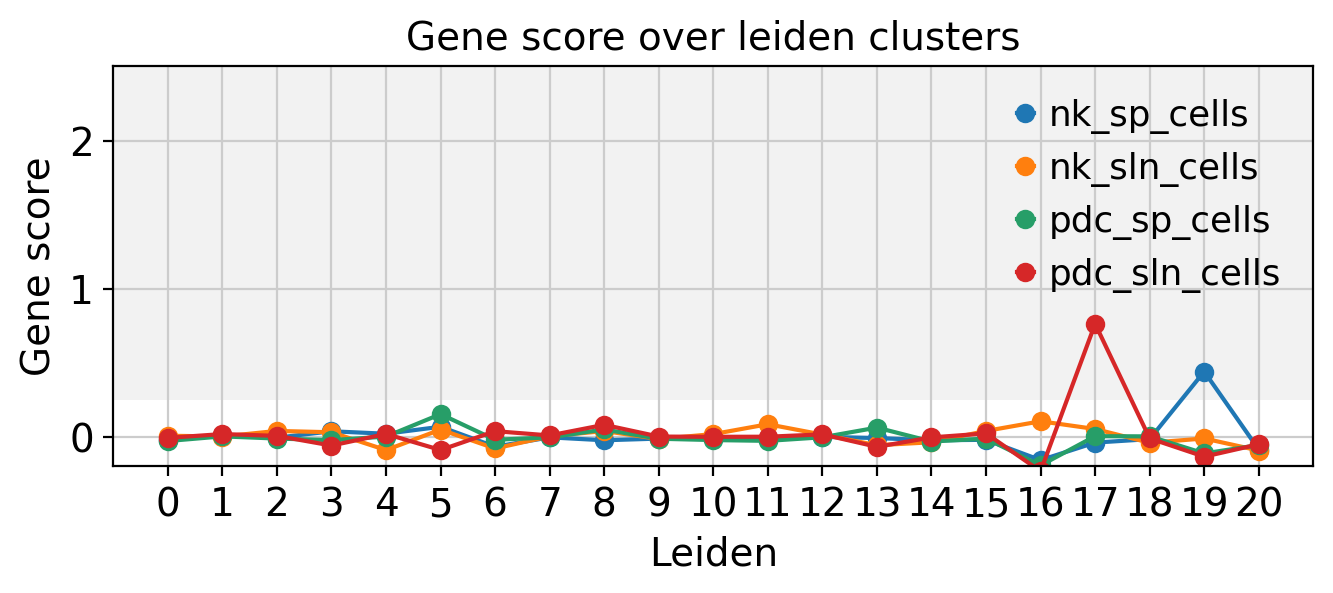

In [39]:
genescores = adata.obs.groupby('leiden')[['nk_sp_cells', 'nk_sln_cells', 
                                          'pdc_sp_cells', 'pdc_sln_cells']].mean()
fig, axs = init_subplots_exact(1, 1, fgsz=(6, 2), dpi = 100)
for col in genescores:
    plt.plot(genescores[col], marker='o', label=col)
plt.axhspan(.25, 3, color='black', alpha=.05, linewidth=0)
plt.legend(frameon=False)
plt.ylim([-.2, 2.5])
plt.ylabel("Gene score")
plt.title("Gene score over leiden clusters")
plt.xlabel("Leiden")

Visualize these gene scores over leiden clusters and as violinplots

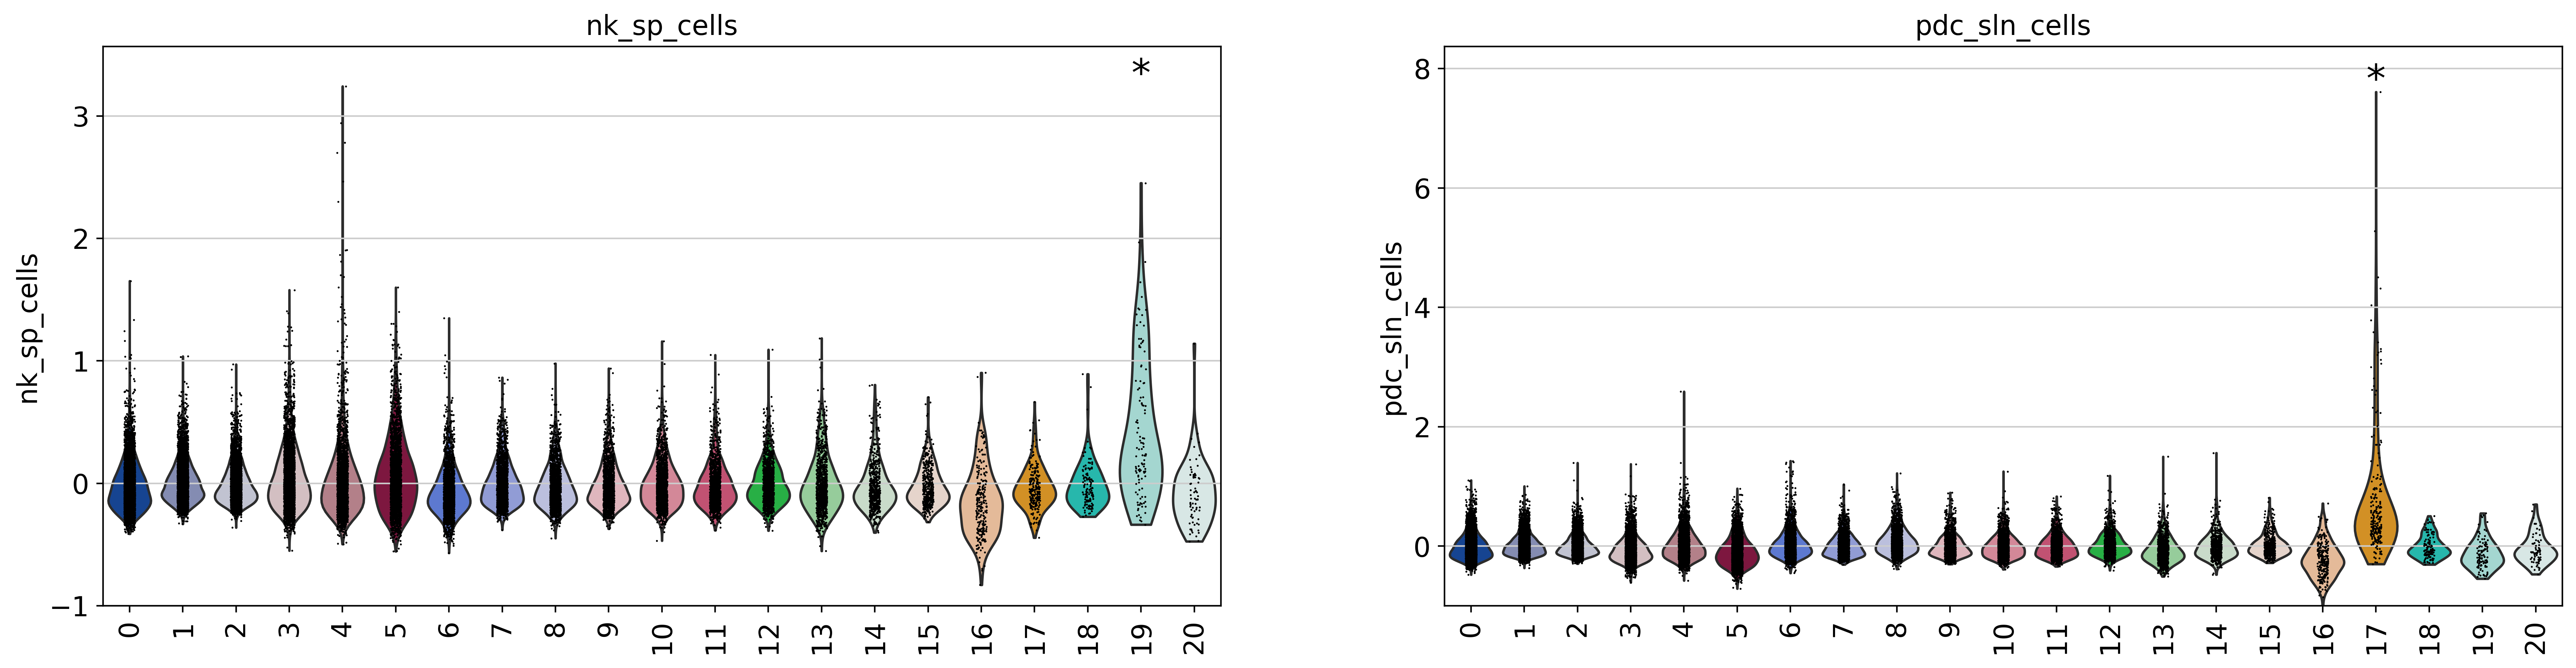

In [40]:
fig, axs = init_subplots_exact(2, 1, fgsz=(8, 4), dpi = 200)
for c, key in enumerate(['nk_sp_cells', 'pdc_sln_cells']):
    sc.pl.violin(adata, key, ax=axs[c],
                 groupby='leiden', 
                 # figsize=(4, 4),
                 rotation=90,
                 show=False,
                )
    plt.sca(axs[c])
    for leiden in adata.obs['leiden'].unique():
        idx = adata.obs['leiden']==leiden
        nonidx = adata.obs['leiden']!=leiden
        _, p = scipy.stats.ttest_ind(adata.obs.loc[idx, key], adata.obs.loc[nonidx, key])
        delta = adata.obs.loc[idx, key].mean() - adata.obs.loc[nonidx, key].mean()
        if (p < 1e-10) and (_ > 0) and (delta > .4):
            plt.text(int(leiden), adata.obs[key].max(), '*', ha='center', fontsize=20)
    plt.title(key)
    plt.ylim([-1, adata.obs[key].max()*1.1])

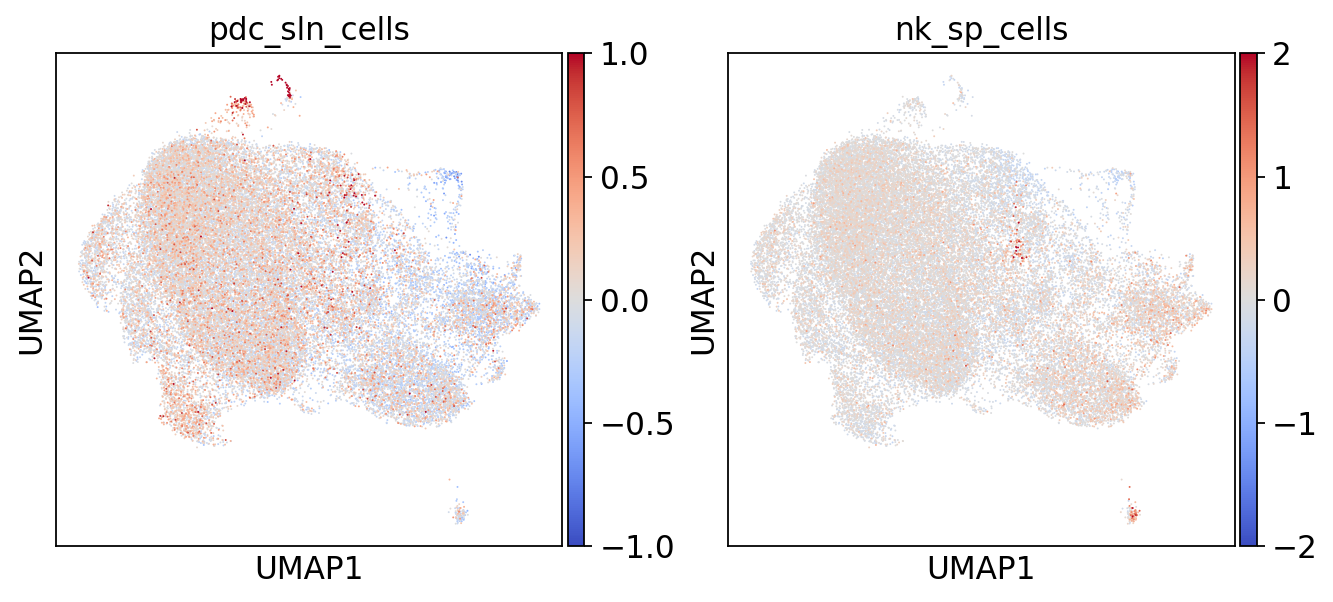

In [41]:
sc.pl.umap(adata, color=['pdc_sln_cells', 'nk_sp_cells'], 
           cmap='coolwarm', vmax=[1, 2], vmin=[-1, -2])

Filter out clusters high in these scores

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


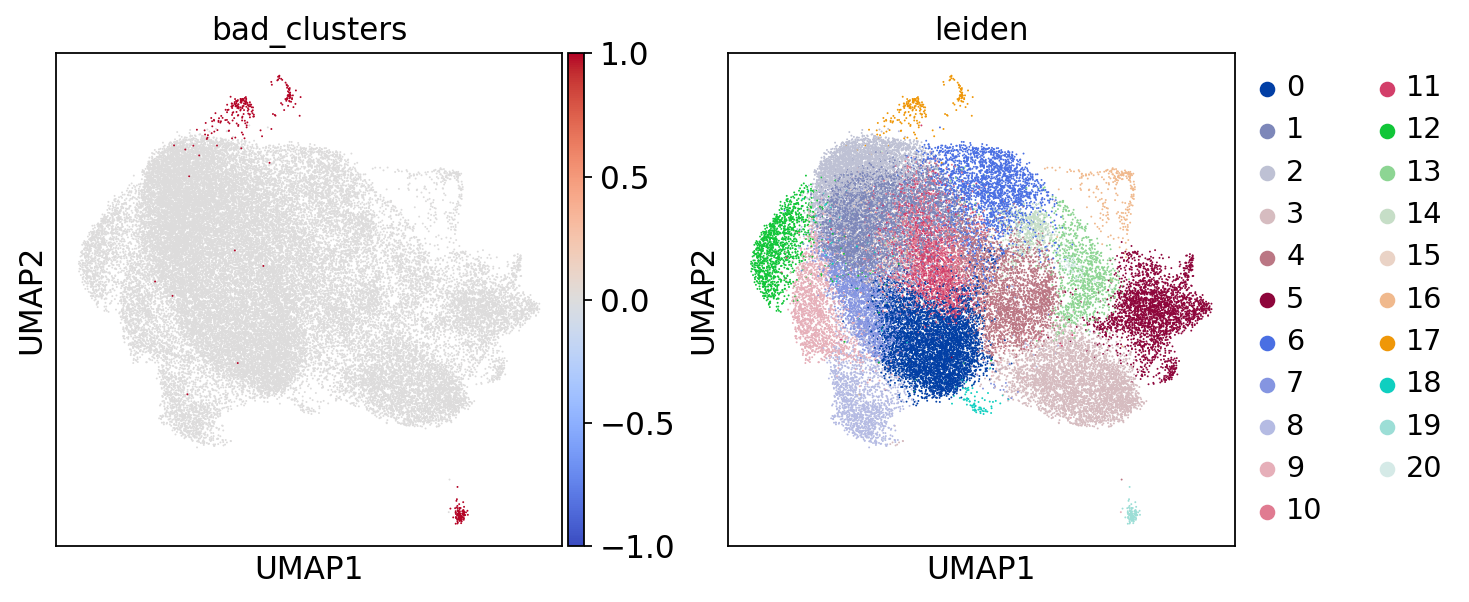

In [42]:
clusters_to_filter = genescores.index[(genescores>.25).any(axis=1)]

adata.obs['bad_clusters'] = adata.obs['leiden'].isin(clusters_to_filter).astype(int)

sc.pl.umap(adata, color = ['bad_clusters',  'leiden'],
          cmap = 'coolwarm', vmax = 1, vmin = -1)

In [43]:
adata = adata[adata.obs['bad_clusters'] == 0]

#### Import bulk RNA-seq; score cells by Active/Resting signature

We want to identify resting/active T cells to perform differential expression separately

In [44]:
from init_bulk_RNA import *
gene_dict, gene_set_dict = init_gene_dicts(path='../../peaks/*thresh*')

conds_to_score = [
         'Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5', 'Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5',
         'Treg_rest_Treg_rest_vs_Tcon_rest_thresh=0.5', 'Treg_actv_Treg_actv_vs_Tcon_actv_thresh=0.5'
         ]

for cond, genes in gene_set_dict.items():
    if cond not in conds_to_score:
        continue
    sc.tl.score_genes(adata, genes, score_name=cond)

computing score 'Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


    finished: added
    'Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5', score of gene set (adata.obs).
    1164 total control genes are used. (0:00:02)
computing score 'Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'
    finished: added
    'Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5', score of gene set (adata.obs).
    1171 total control genes are used. (0:00:01)
computing score 'Treg_rest_Treg_rest_vs_Tcon_rest_thresh=0.5'
    finished: added
    'Treg_rest_Treg_rest_vs_Tcon_rest_thresh=0.5', score of gene set (adata.obs).
    1148 total control genes are used. (0:00:01)
computing score 'Treg_actv_Treg_actv_vs_Tcon_actv_thresh=0.5'
    finished: added
    'Treg_actv_Treg_actv_vs_Tcon_actv_thresh=0.5', score of gene set (adata.obs).
    1163 total control genes are used. (0:00:01)


#### Re-run PCA & clustering after removing artifactual clusters

After removing these clusters we re-run PCA and clustering in case it biased the results in any way

In [45]:
n_pcs = 100
sc.tl.pca(adata, n_comps=n_pcs, svd_solver='arpack')
## we like cosine similarity more so than Euclidean (better silhouettes once clustering)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs, use_rep='X_pca', metric="cosine")
sc.tl.leiden(adata, resolution = 1)
sc.tl.umap(adata)

computing PCA
    with n_comps=100
    finished (0:00:36)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:02)
    computed connectivities (0:00:05)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:38)


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/scrna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


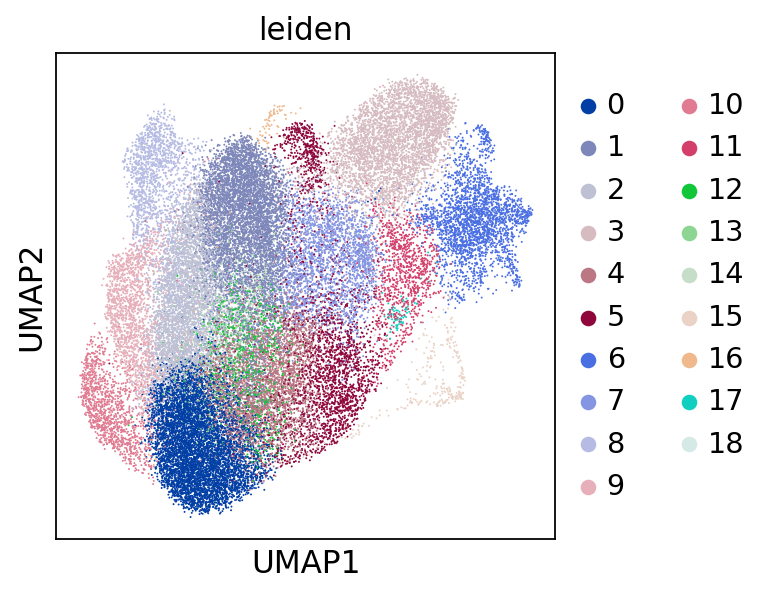

In [46]:
sc.pl.umap(adata, color=['leiden'],  cmap='coolwarm', vmax = [8, 10_000])


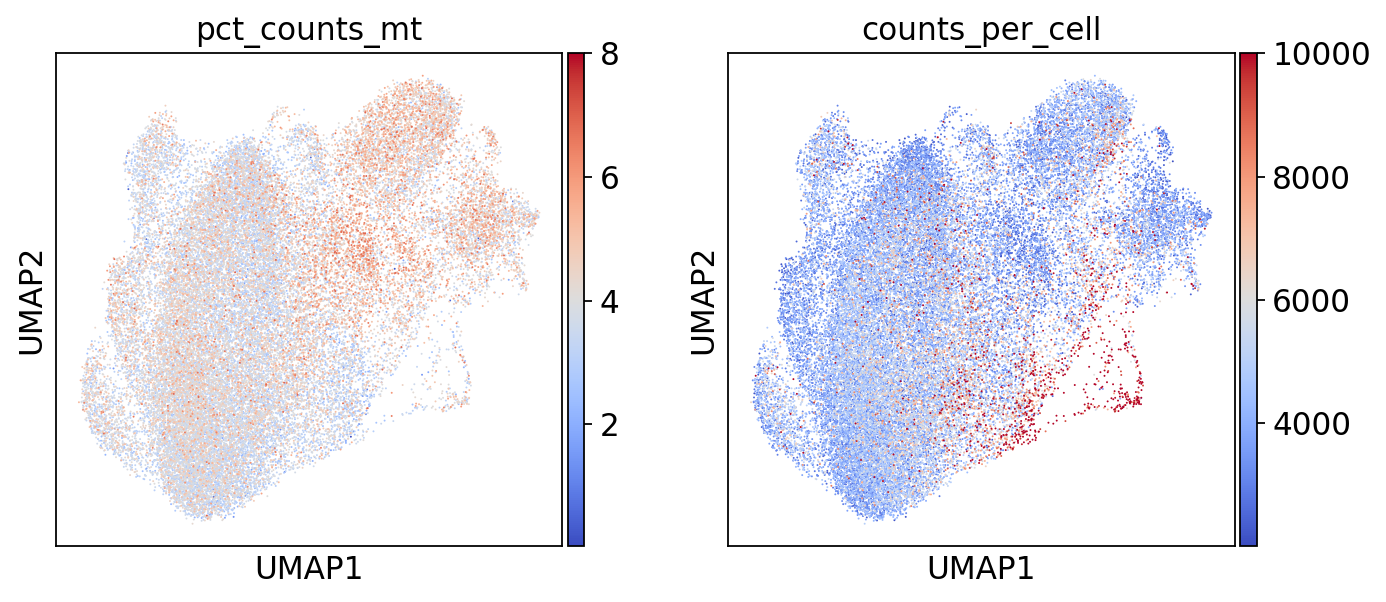

In [47]:
sc.pl.umap(adata, color=['pct_counts_mt', 'counts_per_cell'],  cmap='coolwarm', vmax = [8, 10_000])


### Split cells into active/resting using bulk gene sets

Here we decide cutoffs for active/resting cells

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


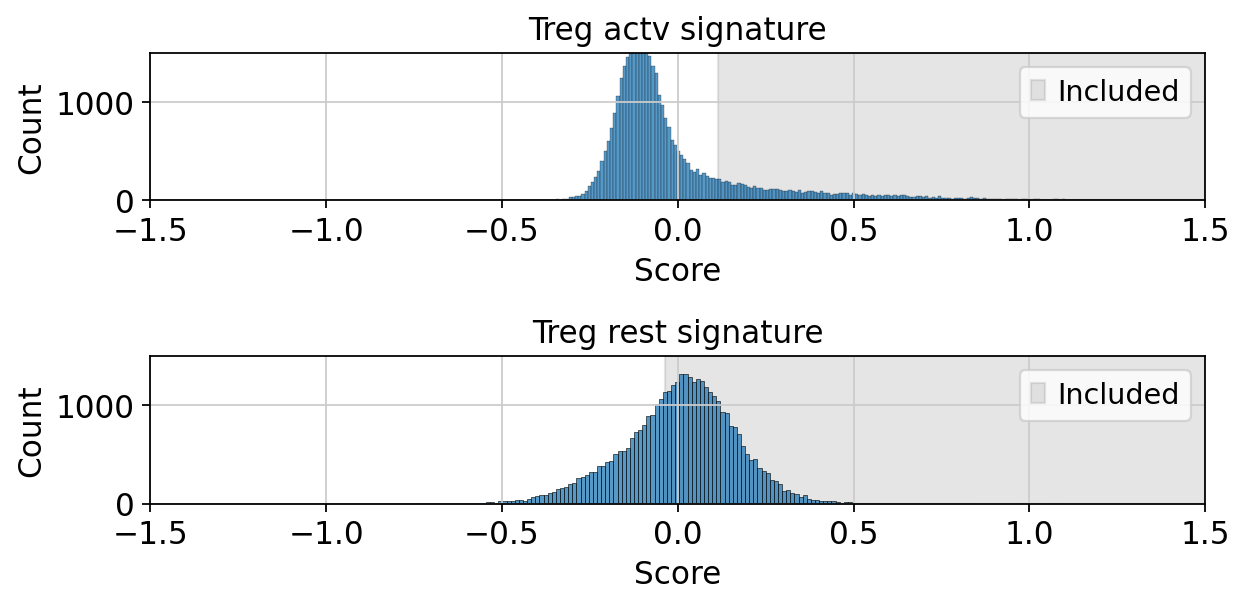

In [48]:
%load_ext autoreload
%autoreload  2
import sys
sys.path.append('./code')
from aux_functions_scRNA import *

fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=False)
keys = ['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5', 'Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5']
for c, key in enumerate(keys):
    sns.histplot(adata.obs[key], ax=axs[c], zorder=1)
    axs[c].set_title(' '.join(key.split("_")[:2]) + " signature")

for ax in axs:
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([0, 1500])
axs[0].axvspan(compute_cutoff(adata.obs[keys[0]], .5), 1.5, color='gray', alpha=.2, zorder=-1, label='Included')
axs[1].axvspan(compute_cutoff(adata.obs[keys[1]], -.25), 1.5, color='gray', alpha=.2, zorder=0, label='Included')
axs[0].set_xlabel("Score")
axs[1].set_xlabel("Score")
axs[0].legend()
axs[1].legend()
plt.tight_layout()

In [49]:
adata.obs['cell_is_active'] = cutoff_vector(adata.obs['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'], .5).astype(int)
adata.obs['cell_is_resting'] = (cutoff_vector(adata.obs['Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'], -.25) & (~ adata.obs['cell_is_active'])).astype(int)

adata.obs.loc[adata.obs['cell_is_resting']==1, 'cell_is_resting_plot'] = 'Resting'
adata.obs.loc[adata.obs['cell_is_resting']==0, 'cell_is_resting_plot'] = 'Not resting'
adata.obs.loc[adata.obs['cell_is_active']==1, 'cell_is_active_plot'] = 'Active'
adata.obs.loc[adata.obs['cell_is_active']==0, 'cell_is_active_plot'] = 'Not active'

adata.obs['cluster_is_active'] = (adata.obs['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'] > np.inf).astype(int)
adata.obs['cluster_is_resting'] = (adata.obs['Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'] > np.inf).astype(int)
for u in np.unique(adata.obs['leiden']):    
    val = adata[adata.obs['leiden'] == u].obs['Treg_rest_Treg_actv_vs_Treg_rest_thresh=0.5'].mean()
    if val > .1:
        adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_resting'] = 'Resting'
    else:
        adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_resting'] = "Not resting"
        
    val = adata[adata.obs['leiden'] == u].obs['Treg_actv_Treg_actv_vs_Treg_rest_thresh=0.5'].mean()
    if val > .1:
        adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_active'] = "Active"
    else:
        adata.obs.loc[adata.obs['leiden'] == u, 'cluster_is_active'] = "Not active"

In [50]:
adata.obs['cell_is_not_active_or_resting'] = ~((adata.obs['cell_is_resting']>0) | (adata.obs['cell_is_active']>0))

#### Save count data to run initial round of DESeq2

Here we save our count data to run DESeq2

In [51]:
active_counts = make_df_aggregated_by_key(adata, adata.var.index, key='sample', 
                          leiden='cell_is_active', layer='raw_counts', 
                          useLog=False,
                          pc=0, agg_func=np.sum)

resting_counts = make_df_aggregated_by_key(adata, adata.var.index, key='sample', 
                          leiden='cell_is_resting', layer='raw_counts', 
                          useLog=False, 
                          pc=0, agg_func=np.sum)

In [52]:
count_rest_df = resting_counts[resting_counts['cell_is_resting'] > 0].pivot(index='gene', columns=['sample'], values='value')

count_actv_df = active_counts[active_counts['cell_is_active'] > 0].pivot(index='gene', columns=['sample'], values='value')

In [53]:
!mkdir -p bulk_rna_data/DESeq2/sc_counts_INIT

In [54]:
count_rest_df.to_csv('./bulk_rna_data/DESeq2/sc_counts_INIT/count_rest_df.csv')
count_actv_df.to_csv('./bulk_rna_data/DESeq2/sc_counts_INIT/count_active_df.csv')
col_data = pd.DataFrame(count_rest_df.columns.str.replace("_rep[0-9]", '', regex=True), index=list(count_rest_df.columns))
col_data.to_csv('./bulk_rna_data/DESeq2/sc_counts_INIT/colData.csv')